<a href="https://colab.research.google.com/github/CesarMagnoJr/CeNN/blob/main/AD_Lorenz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

INSTRUMENT INITIALIZATION

In [156]:
# LORENZ-63 MODEL PARAMETERS
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

# PERFORM ASSIMILATION EVERY
P_AD = 10

# NUMBER OF ASSIMILATIONS
N1_AD = 50
N2_AD = 50 # FOR WHEN THE SYSTEM RESTARTS AT SOME POINT, OTHERWISE, N2_AD = 0
N_AD = N1_AD + N2_AD

# NUMBER OF TIME STEPS
num_steps = 3000
dt = 0.01

# CeNN ITERATIONS FOR ASSIMILATIONS
I_CNN = 50
Bias = 0

# VALUE TO AVOID DIVISION BY ZERO IN CeNN
eps1 = 10e-4


LORENZ-63 WITHOUT ASSIMILATION AND PRODUCTION OF SYNTHETIC OBSERVATION

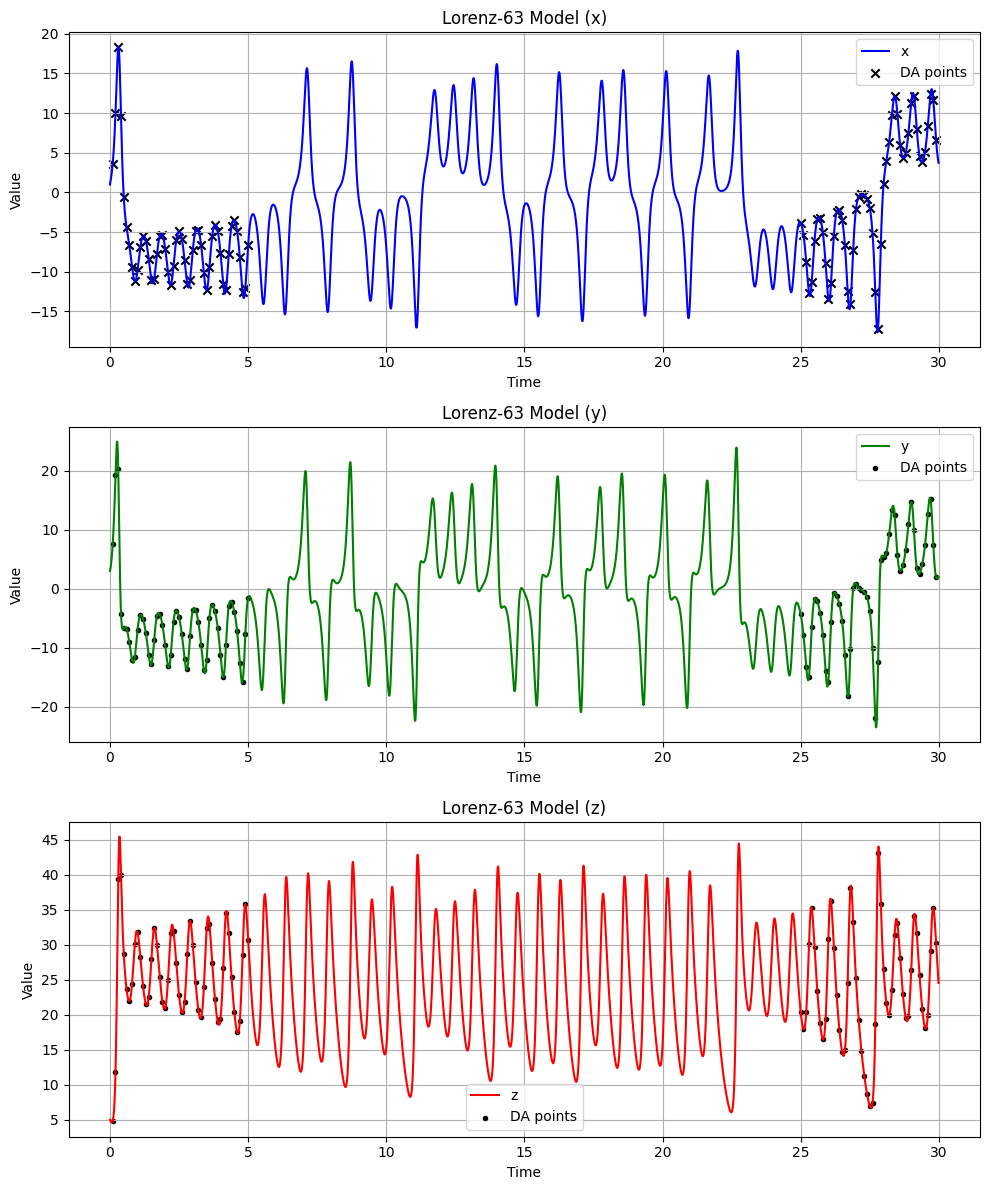

In [149]:
# INITIAL CONDITIONS 
initial_state = np.array([1.0, 3.0, 5.0])

def lorenz_63(t, state):
    x, y, z = state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return np.array([dx_dt, dy_dt, dz_dt])

def runge_kutta(f, t, dt, y):
    k1 = dt * f(t, y)
    k2 = dt * f(t + 0.5 * dt, y + 0.5 * k1)
    k3 = dt * f(t + 0.5 * dt, y + 0.5 * k2)
    k4 = dt * f(t + dt, y + k3)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6

# ARRAYS TO STORE THE RESULTS
t_values = np.zeros(num_steps)
xr_values = np.zeros(num_steps)
yr_values = np.zeros(num_steps)
zr_values = np.zeros(num_steps)

state = initial_state

# POINTS WHERE ASSIMILATION CYCLES WILL OCCUR
obs_points = []
obs = [[], [], []]
for w in range(1, N1_AD + 1, 1):
    obs_points.append(P_AD * w)
for w in range(0, N2_AD, 1):
    obs_points.append(2500 + P_AD * w)

# INTEGRATION LOOP THE DIFFERENTIAL EQUATIONS
for i in range(num_steps):
    # GENERATING SYNTHETIC OBSERVATIONS
    for k in range(0, N_AD, 1):
        if i == obs_points[k]:
            obs[0].append(state[0])
            obs[1].append(state[1])
            obs[2].append(state[2])
    t_values[i] = i * dt
    xr_values[i] = state[0]
    yr_values[i] = state[1]
    zr_values[i] = state[2]
    state = runge_kutta(lorenz_63, i * dt, dt, state)

# CREATE THE FIGURE AND SUBPLOTS
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
colors = ['blue', 'green', 'red']
for i, (ax, color) in enumerate(zip(axs, colors)):
    ax.plot(t_values, [xr_values, yr_values, zr_values][i], label=['x', 'y', 'z'][i], color=color)
    ax.scatter(np.array(obs_points)/100, obs[i], label='DA points', color='black', marker='x' if i == 0 else '.')
    ax.set_title('Lorenz-63 Model (' + ['x', 'y', 'z'][i] + ')')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()


GENERATING NOISE

In [150]:
RUIDOX = (1 + 0.05 * (np.random.uniform(-1,1,N_AD) ) )
RUIDOY = (1 + 0.05 * (np.random.uniform(-1,1,N_AD) ) )
RUIDOZ = (1 + 0.05 * (np.random.uniform(-1,1,N_AD) ) )
w = []
for i in range(0,N_AD,1):
  wx = obs[0][i]*(RUIDOX[i])
  wy = obs[1][i]*(RUIDOY[i])
  wz = obs[2][i]*(RUIDOZ[i])
  w.append([wx,wy,wz])

LORENZ WITH 20% NOISE AND DATA ASSIMILATION

In [157]:
# INITIAL CONDITIONS
initial_state = np.array([1.2, 3.6, 6.0])

def lorenz_63(t, state):
    x, y, z = state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return np.array([dx_dt, dy_dt, dz_dt])

def runge_kutta(f, t, dt, y):
    k1 = dt * f(t, y)
    k2 = dt * f(t + 0.5 * dt, y + 0.5 * k1)
    k3 = dt * f(t + 0.5 * dt, y + 0.5 * k2)
    k4 = dt * f(t + dt, y + k3)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6

# ARRAYS TO STORE THE RESULTS
t_values = np.zeros(num_steps)
x_values = np.zeros(num_steps)
y_values = np.zeros(num_steps)
z_values = np.zeros(num_steps)

state = initial_state

# CeNN FUNCTION
function_deriv = lambda a, b, x, y, z, bs : -x + y + z + bs

# LOOP FOR INTEGRATING THE DIFFERENTIAL EQUATIONS
for i in range(num_steps):

  # BEGINNING OF DATA ASSIMILATION by CeNN:
  for q in range(0, N_AD, 1):
    if i == obs_points[q]:
      UI = state
      for k in range(0, I_CNN, 1): # NUMBER OF CeNN ITERATIONS PER ASSIMILATION CYCLE
        for j in range(0, 3, 1):
          Cx = UI[0] * (w[q][j] / (state[0])) / 3 + UI[1] * (w[q][j] / (state[1])) / 3 + UI[2] * (w[q][j] / (state[2])) / 3
          if i == 0:
            Nl = -(state[0] - w[q][0]) / (10)
          if i == 1:
            Nl = -(state[1] - w[q][1]) / (10)
          if i == 2:
            Nl = -(state[2] - w[q][2]) / (10)

          # CELL DERIVATIVE CALCULATION
          x_deriv = function_deriv(0, 0, state[j], Cx, Nl, Bias)

          # CELL INTEGRAL CALCULATION
          x_integ = solve_ivp(function_deriv, [0, 0.1], [state[j]], args=(state[j], Cx, Nl, Bias), method='RK45')
          
          # UPDATE OF THE CELL
          x_novo = float(x_integ.y[0][1])
          if abs(x_novo) <= 10e-6:
            if x_novo < 0:
              x_novo = x_novo - eps1
            else:
              x_novo = x_novo + eps1
          state[j] = x_novo

  t_values[i] = i * dt
  x_values[i] = state[0]
  y_values[i] = state[1]
  z_values[i] = state[2]
  state = runge_kutta(lorenz_63, i * dt, dt, state)


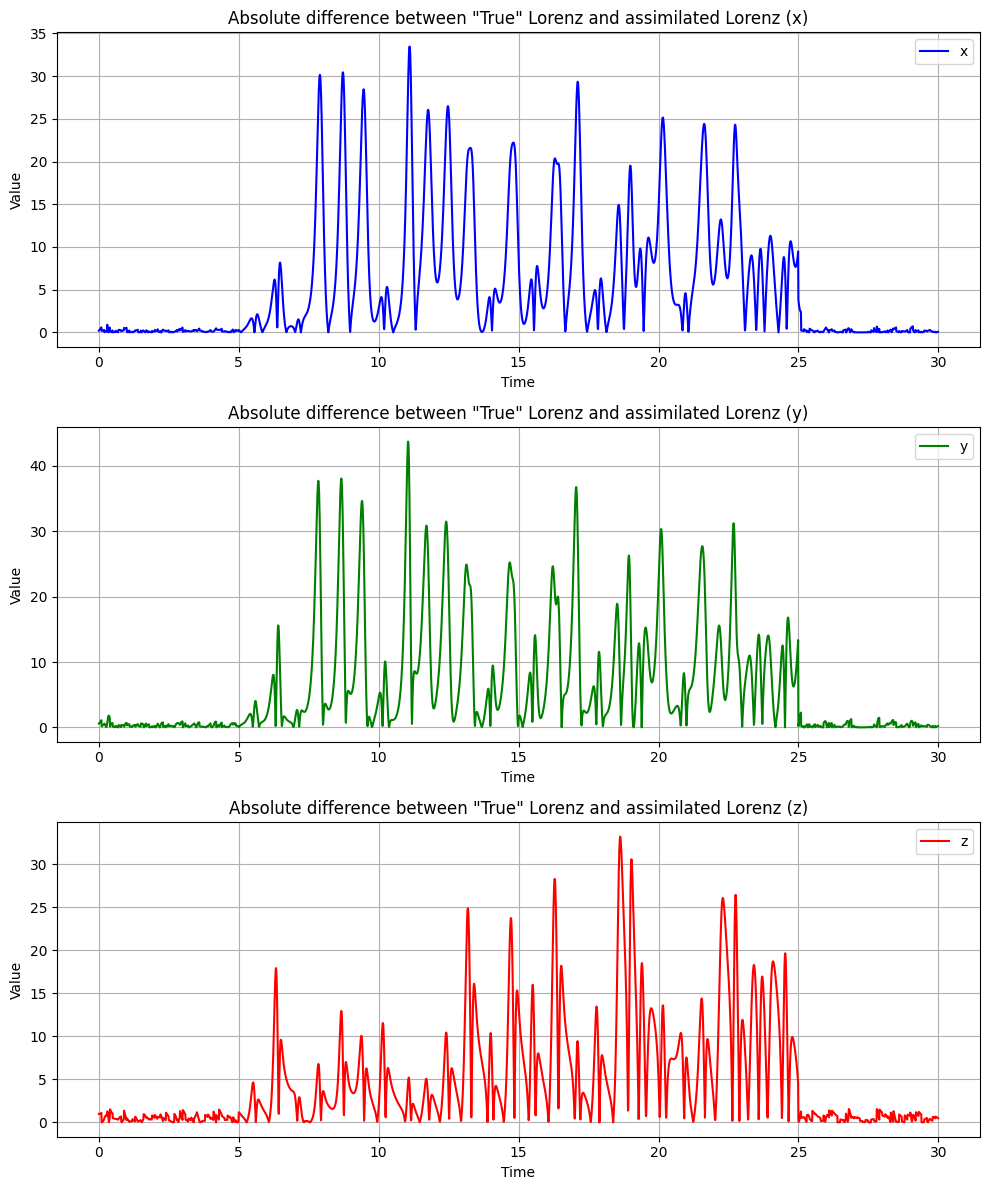

In [155]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
colors = ['blue', 'green', 'red']
for i, (ax, color) in enumerate(zip(axs, colors)):
    ax.plot(t_values, [np.abs(xr_values - x_values), np.abs(yr_values - y_values), np.abs(zr_values - z_values)][i], label=['x', 'y', 'z'][i], color=color)
    ax.set_title('Absolute difference between "True" Lorenz and assimilated Lorenz (' + ['x', 'y', 'z'][i] + ')')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

LORENZ ATTRACTOR PLOT

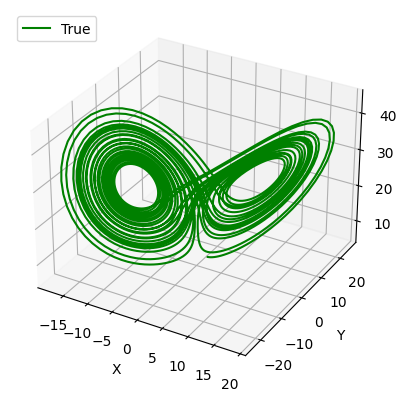

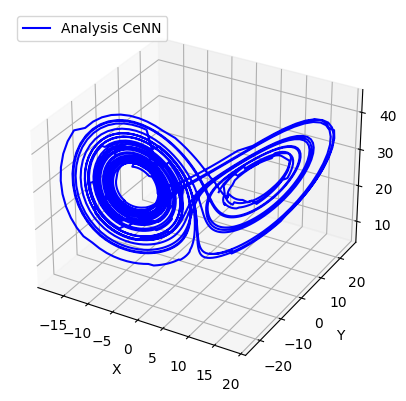

In [164]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xr_values, yr_values, zr_values, color='green', label='True')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(loc='upper left')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_values, y_values, z_values, color='blue', label='Analysis CeNN')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(loc='upper left')
plt.show()